In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

In [86]:
train_t= pd.read_csv('/Users/krc/Documents/dev/Mini_project-modeling/data/train_transaction.csv')
train_i = pd.read_csv('/Users/krc/Documents/dev/Mini_project-modeling/data/train_identity.csv')

test_t= pd.read_csv('/Users/krc/Documents/dev/Mini_project-modeling/data/test_transaction.csv')
test_i = pd.read_csv('/Users/krc/Documents/dev/Mini_project-modeling/data/test_identity.csv')
submission = pd.read_csv('/Users/krc/Documents/dev/Mini_project-modeling/data/sample_submission.csv')

In [87]:
train_m = train_t.merge(train_i, how='left', on='TransactionID')
test_m = test_t.merge(test_i, how='left', on='TransactionID')

TransactionID 제외

1. 결측치 -999 fillna
2. object columns -> label encoding
3. feature importance check
4. 상위 column 구분
5. object columns -> one-hot encoding
6. feature importance check
7. 상위 column 구분
8. 모델생성 및 평가

In [7]:
train_t.dtypes[train_t.dtypes.values=='object']

ProductCD        object
card4            object
card6            object
P_emaildomain    object
R_emaildomain    object
M1               object
M2               object
M3               object
M4               object
M5               object
M6               object
M7               object
M8               object
M9               object
dtype: object

In [15]:
def null(df,col):
    return df[col].isnull().sum()

In [28]:
null(train_t, 'card4')

1577

In [27]:
train_t.loc[:,['card4','card6']]

,card4,card6
0,discover,credit
1,mastercard,credit
2,visa,debit
3,mastercard,debit
4,mastercard,credit
...,...,...
590535,visa,debit
590536,mastercard,debit
590537,mastercard,debit
590538,mastercard,debit


In [30]:
train_t.card4.unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

<AxesSubplot:xlabel='TransactionID', ylabel='Count'>

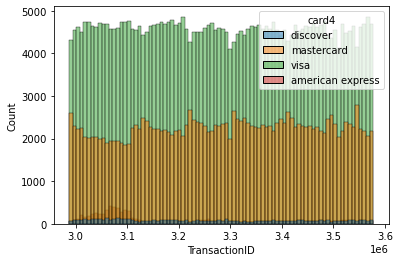

In [37]:
sns.histplot(data=train_t,x='TransactionID', hue='card4')

<AxesSubplot:xlabel='card4', ylabel='Count'>

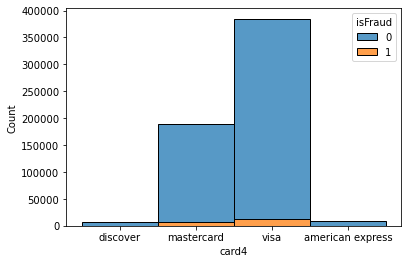

In [40]:
sns.histplot(x="card4", data=train_t, hue='isFraud',multiple='stack' )

In [43]:

train_t[(train_t.card4.isnull()==True) & (train_t.isFraud==1)]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
28994,3015994,1,744757,40.000,W,5178,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29013,3016013,1,744980,49.000,W,5178,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195706,3182706,1,4401965,250.000,R,16032,138.0,200.0,NaN,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313838,3300838,1,7827862,171.000,W,15981,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313869,3300869,1,7828331,285.000,W,5492,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313873,3300873,1,7828385,280.000,W,12839,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313965,3300965,1,7830347,117.000,W,5033,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314002,3301002,1,7830955,226.000,W,15063,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314036,3301036,1,7831600,268.950,W,10023,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314082,3301082,1,7832480,614.000,W,15063,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
test_t.R_emaildomain.isnull().sum()

370821

<AxesSubplot:xlabel='P_emaildomain', ylabel='Count'>

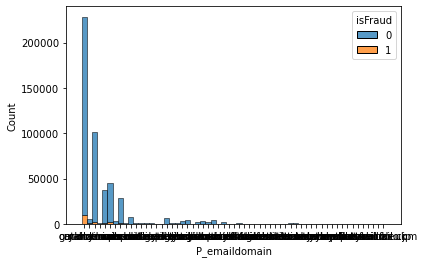

In [45]:
sns.histplot(x="P_emaildomain", data=train_t, hue='isFraud',multiple='stack' )

<AxesSubplot:>

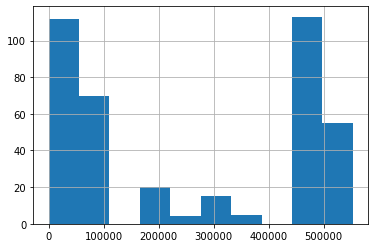

In [55]:
train_t.isnull().sum().hist()

In [48]:
from sklearn.preprocessing import LabelEncoder

In [83]:
train_m.fillna(-999, inplace=True)
test_m.fillna(-999, inplace=True)

In [88]:
X = train_m.drop(columns=['isFraud','TransactionID'])
y = train_m.isFraud

In [89]:
X[list(train_m.dtypes[train_m.dtypes.values=='object'].index)] = X[list(train_m.dtypes[train_m.dtypes.values=='object'].index)].apply(LabelEncoder().fit_transform)

In [90]:
X.fillna(-999, inplace=True)

Feature ranking:
1. feature TransactionDT (0.031)
2. feature TransactionAmt (0.027)
3. feature card1 (0.026)
4. feature card2 (0.023)
5. feature addr1 (0.020)
6. feature C1 (0.017)
7. feature C13 (0.017)
8. feature C14 (0.012)
9. feature P_emaildomain (0.012)
10. feature card5 (0.012)
11. feature V244 (0.011)
12. feature V258 (0.011)
13. feature V45 (0.010)
14. feature D15 (0.010)
15. feature C2 (0.010)
16. feature C11 (0.009)
17. feature C6 (0.009)
18. feature dist1 (0.009)
19. feature D2 (0.009)
20. feature D1 (0.009)
21. feature C12 (0.008)
22. feature id_02 (0.008)
23. feature V307 (0.008)
24. feature D10 (0.007)
25. feature D4 (0.007)
26. feature V242 (0.007)
27. feature V257 (0.007)
28. feature V189 (0.007)
29. feature V201 (0.007)
30. feature V310 (0.007)
31. feature V308 (0.006)
32. feature V188 (0.006)
33. feature C4 (0.006)
34. feature V200 (0.006)
35. feature id_31 (0.006)
36. feature id_20 (0.006)
37. feature C8 (0.006)
38. feature card4 (0.006)
39. feature V44 (0.006)
40. 

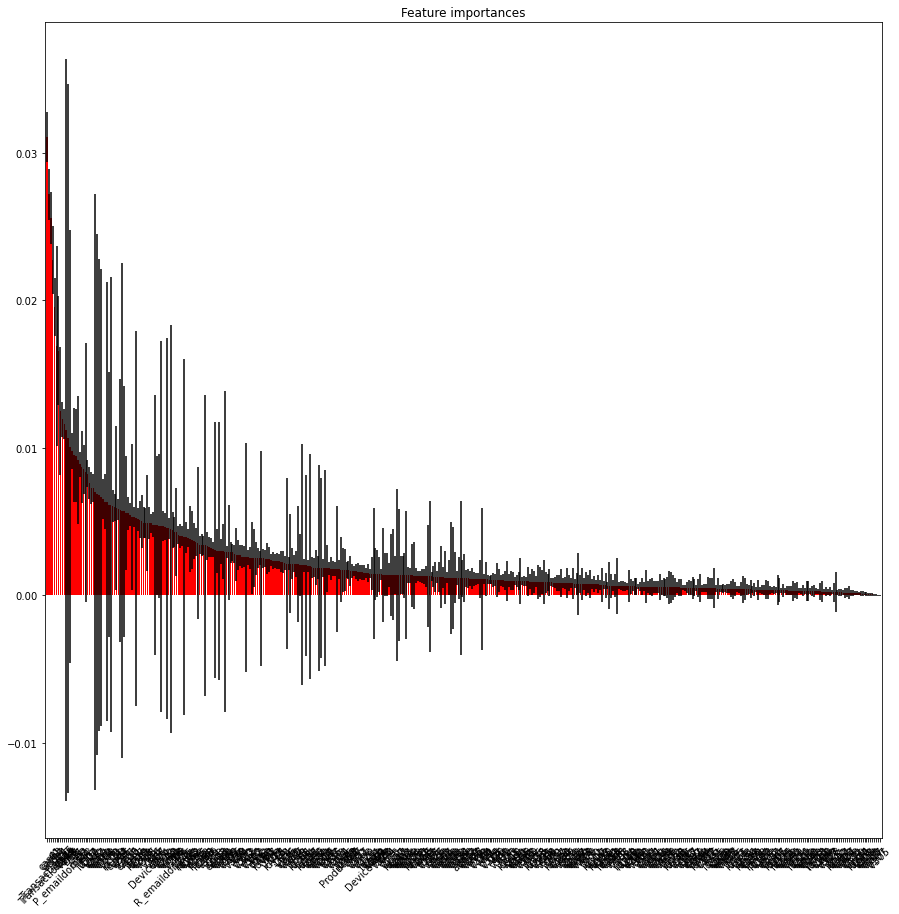

In [91]:
forest = RandomForestClassifier()
forest.fit(X,y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('Feature ranking:')

for f in range(X.shape[1]):
    print('{}. feature {} ({:.3f})'.format(f + 1, X.columns[indices][f], importances[indices[f]]))

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color='r', yerr=std[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

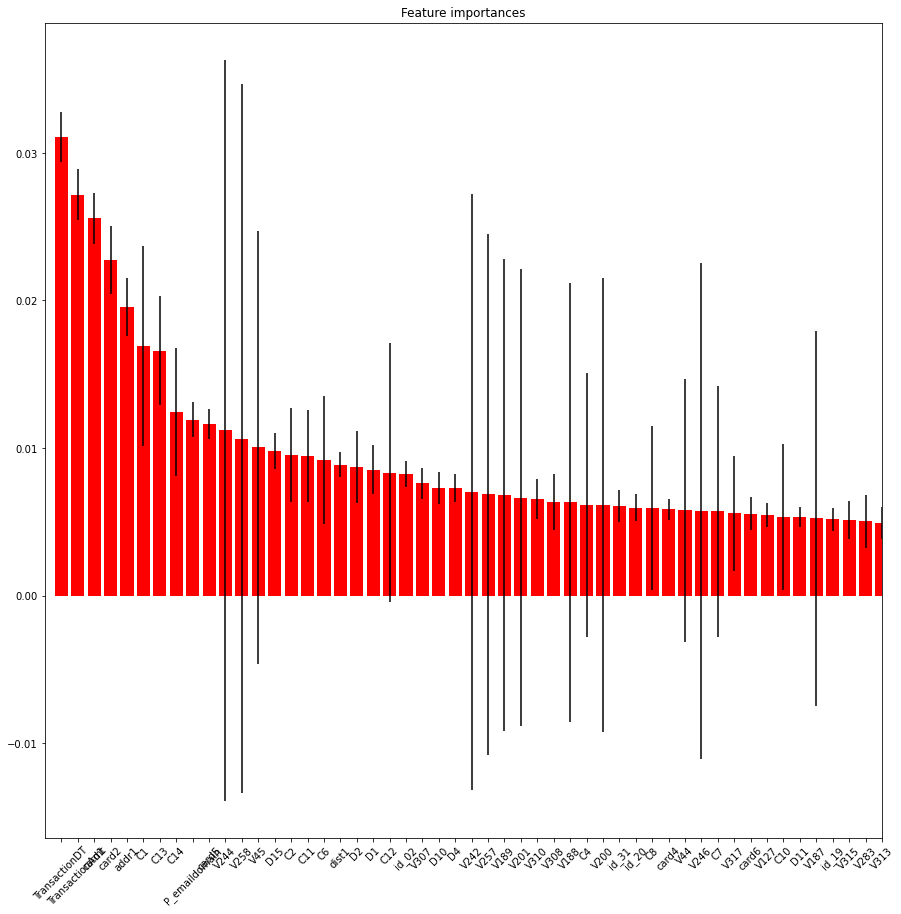

In [93]:
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color='r', yerr=std[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, 50])
plt.show()

Feature ranking:
1. feature DeviceInfo (0.209)
2. feature id_31 (0.157)
3. feature P_emaildomain (0.128)
4. feature R_emaildomain (0.071)
5. feature id_30 (0.057)
6. feature id_33 (0.055)
7. feature card4 (0.050)
8. feature card6 (0.041)
9. feature M4 (0.031)
10. feature ProductCD (0.028)
11. feature id_38 (0.015)
12. feature id_29 (0.014)
13. feature id_12 (0.013)
14. feature DeviceType (0.012)
15. feature M5 (0.012)
16. feature id_16 (0.011)
17. feature M6 (0.011)
18. feature id_37 (0.011)
19. feature id_35 (0.011)
20. feature id_15 (0.010)
21. feature id_34 (0.009)
22. feature id_23 (0.007)
23. feature id_28 (0.007)
24. feature id_36 (0.006)
25. feature id_27 (0.004)
26. feature M8 (0.004)
27. feature M3 (0.004)
28. feature M7 (0.004)
29. feature M2 (0.003)
30. feature M9 (0.003)
31. feature M1 (0.001)


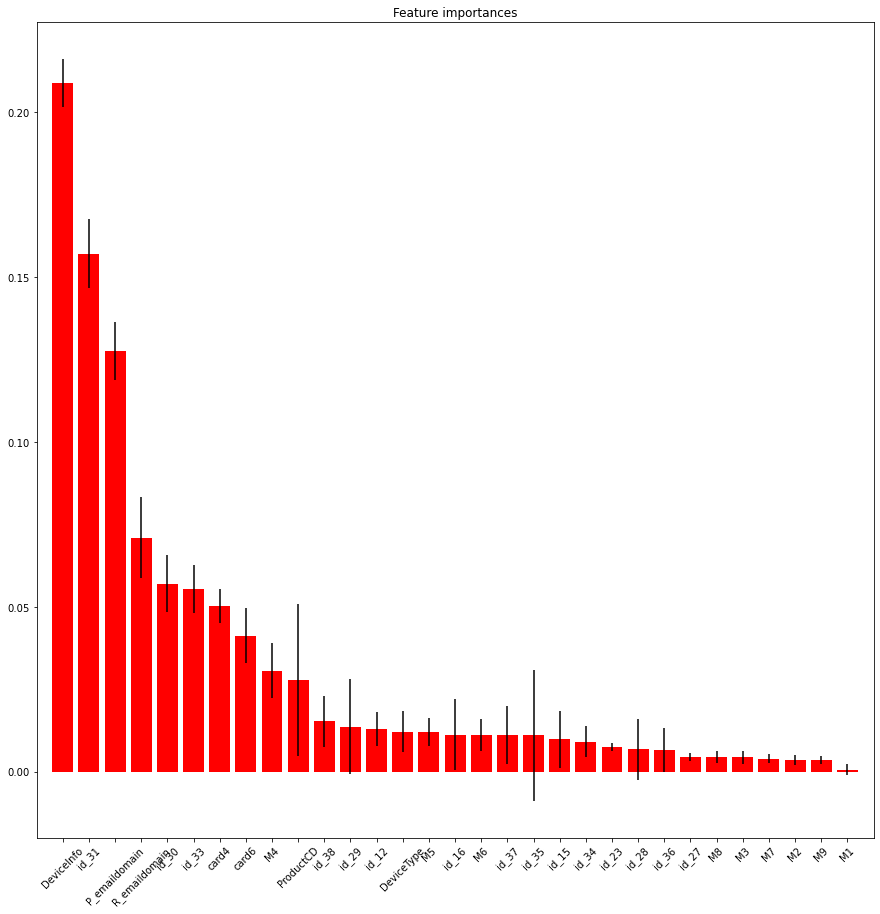

In [76]:
forest = RandomForestClassifier()
forest.fit(X,y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('Feature ranking:')

for f in range(X.shape[1]):
    print('{}. feature {} ({:.3f})'.format(f + 1, X.columns[indices][f], importances[indices[f]]))

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color='r', yerr=std[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()